In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

# paths — update if your files live somewhere else
ROOT = pathlib.Path(".")  # your project root (where the notebook is)
DATA = ROOT / "out" / "torsion360" / "txt"  # where ALLMODELS_torsion360_clean.csv is

# which file to read (made by clean_torsion360.py)
ALLMODELS = DATA / "ALLMODELS_torsion360_clean.csv"

# OPTIONAL: focus window & chain (set to None to use everything)
FOCUS_CHAIN = "A"          # e.g., "A"  (or None)
FOCUS_RANGE = (19, 43)     # e.g., (19, 43)  (or None)

# output folders
PLOTS_DIR = ROOT / "out" / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR = ROOT / "out"
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# torsions we’ll analyze
TORSIONS = ["alpha","beta","gamma","delta","epsilon","zeta","chi","phase-angle"]


In [2]:
df = pd.read_csv(ALLMODELS)

# enforce expected columns
needed = {"model","chain","resn","resi"} | set(TORSIONS)
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"Input file missing columns: {missing}")

# optional focus
mask = pd.Series(True, index=df.index)
if FOCUS_CHAIN is not None:
    mask &= (df["chain"].fillna(FOCUS_CHAIN) == FOCUS_CHAIN)
if FOCUS_RANGE is not None:
    lo, hi = FOCUS_RANGE
    mask &= df["resi"].between(lo, hi)

df = df[mask].copy().reset_index(drop=True)
df.head()


,model,chain,resn,resi,alpha,beta,gamma,delta,epsilon,zeta,chi,phase-angle
0,1ANR_model01,A,C,19,74.6,-140.2,-130.0,93.9,-153.9,-61.2,-163.3,3.9
1,1ANR_model01,A,A,20,-70.6,169.7,56.9,89.2,-160.9,-88.9,-148.7,32.4
2,1ANR_model01,A,G,21,118.8,-163.2,-162.5,93.6,-146.6,-55.7,-171.3,3.2
3,1ANR_model01,A,A,22,-75.3,-178.1,49.2,92.0,-154.3,-63.6,-163.5,21.6
4,1ANR_model01,A,U,23,144.5,-171.9,167.7,95.2,-85.8,-137.9,-164.1,0.6


In [3]:
def circular_sd_deg(deg_vals):
    vals = np.deg2rad(np.asarray(deg_vals, dtype=float))
    if len(vals) < 2:
        return np.nan
    C = np.mean(np.cos(vals))
    S = np.mean(np.sin(vals))
    R = np.hypot(C, S)
    if R <= 0:
        return 180.0/np.sqrt(3.0)  # ~103.92°, “max” dispersion
    return np.degrees(np.sqrt(-2.0*np.log(R)))


In [4]:
# group across models
g = df.groupby(["chain","resi"], sort=True)

# compute circular SD per torsion
sd_cols = {}
for t in TORSIONS:
    sd_cols[f"{t}_sd"] = g[t].apply(lambda x: circular_sd_deg(x.dropna()))

flex = pd.DataFrame(sd_cols).reset_index()

# top_angle & max_sd per residue
sd_only = flex[[c for c in flex.columns if c.endswith("_sd")]]
top_idx = sd_only.values.argmax(axis=1)
angle_names = [c.replace("_sd","") for c in sd_only.columns]
flex["top_angle"] = [angle_names[i] if np.isfinite(sd_only.iloc[j,i]) else np.nan
                     for j,i in enumerate(top_idx)]
flex["max_sd"] = sd_only.max(axis=1)

# sort by residue number for pretty plotting
flex = flex.sort_values(["chain","resi"]).reset_index(drop=True)

# save the detailed table
out_table = TABLES_DIR / "ensemble_flexibility_summary.csv"
flex.to_csv(out_table, index=False)
out_table


WindowsPath('out/ensemble_flexibility_summary.csv')

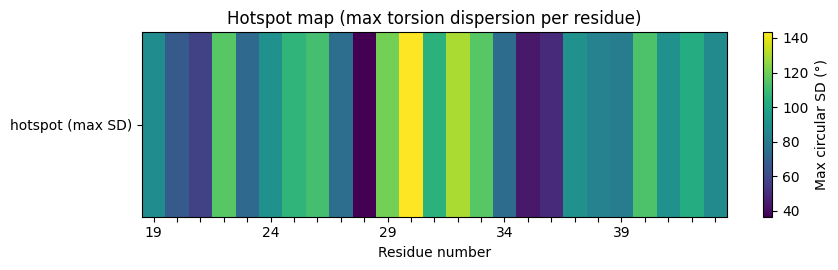

WindowsPath('out/plots/hotspot_map_maxsd.png')

In [5]:
# build x axis
res_nums = flex["resi"].tolist()
maxsd   = flex["max_sd"].to_numpy()

# figure
plt.figure(figsize=(max(8, len(res_nums)/2.8), 2.8))
# draw as 1-row heatmap
plt.imshow(maxsd.reshape(1, -1), aspect="auto", interpolation="nearest")
cbar = plt.colorbar(label="Max circular SD (°)")

# ticks: mark EVERY residue, label every 5
# indices go 0..N-1; labels are residue numbers
plt.yticks([0], ["hotspot (max SD)"])

# set ticks for each residue index
plt.xticks(range(len(res_nums)), res_nums)

# then thin the labels so only every 5th shows (keeps it readable)
for i, label in enumerate(plt.gca().get_xticklabels()):
    label.set_visible((i % 5) == 0)

plt.xlabel("Residue number")
plt.title("Hotspot map (max torsion dispersion per residue)")
plt.tight_layout()

hotspot_png = PLOTS_DIR / "hotspot_map_maxsd.png"
plt.savefig(hotspot_png, dpi=300)
plt.show()

hotspot_png


In [6]:
display_cols = ["chain","resi","top_angle","max_sd"] + [f"{t}_sd" for t in TORSIONS]
flex[display_cols].style.background_gradient(cmap="magma_r", subset=["max_sd"])


,chain,resi,top_angle,max_sd,alpha_sd,beta_sd,gamma_sd,delta_sd,epsilon_sd,zeta_sd,chi_sd,phase-angle_sd
0,A,19,gamma,88.658655,75.599536,20.824210,88.658655,3.327637,12.699862,8.625617,4.694694,14.206730
1,A,20,gamma,66.684805,64.679187,22.050294,66.684805,3.563890,12.057686,22.012141,6.830350,17.423369
2,A,21,alpha,57.112189,57.112189,45.947089,38.550512,4.348317,17.020003,23.786237,6.002615,10.318030
3,A,22,alpha,115.511802,115.511802,30.021676,86.525753,7.527376,42.599802,49.730890,40.958835,36.771143
4,A,23,phase-angle,73.203322,43.696701,30.896569,30.391675,29.014304,20.568839,33.269001,29.647079,73.203322
5,A,24,phase-angle,90.600995,22.788164,32.714116,23.328939,27.452167,28.438820,55.022687,12.469492,90.600995
6,A,25,alpha,106.569821,106.569821,105.121247,67.688525,25.752137,25.492149,56.643737,89.548515,81.587796
7,A,26,gamma,111.903808,82.415617,38.267157,111.903808,3.146971,23.298355,42.908060,13.449368,16.099871
8,A,27,beta,75.099920,61.684802,75.099920,36.365692,5.170339,5.558018,3.239775,10.555184,28.274890
9,A,28,gamma,36.691625,36.300101,22.412586,36.691625,8.641148,16.701364,14.969393,5.175819,29.180072


In [7]:
flex.nlargest(10, "max_sd")[["chain","resi","top_angle","max_sd"]]


,chain,resi,top_angle,max_sd
11,A,30,alpha,143.242669
13,A,32,alpha,129.848342
10,A,29,gamma,120.865998
3,A,22,alpha,115.511802
14,A,33,phase-angle,115.510310
21,A,40,gamma,113.527802
7,A,26,gamma,111.903808
6,A,25,alpha,106.569821
12,A,31,alpha,105.318589
23,A,42,gamma,102.501349


In [ ]:
!pip install dataframe-image
